# AI for stock market prediction: Using LLMs for TimeSeries Predictions (LLMTime implementation)

Project by: Jana Nikolovska <br>
Supervised by: Giacomo Frisoni, MSc <br><!--  -->
Prof. Gianluca Moro, PhD <br>

ALMA MATER STUDITORIUM - University of Bologna <br>
November 2025

---

**Summary:** <br>
In this project, I explore the use of Large Language Models (LLMs) for time series forecasting, focusing on the task of stock market prediction. The work was proposed and mentored by Prof. Gianluca Moro and Giacomo Frisoni at the University of Bologna.

As a starting point, I used a provided notebook by my mentors. The notebook introduces the dataset (**historical S&P 500 data via [`yfinance`](https://pypi.org/project/yfinance/)**), a basic linear regression model, which I chose not to include in the final results, that served as an early benchmark and highlighted the underlying complexity of the forecasting problem and finally, the **"Trading Protocol"** — a framework designed to evaluate forecasting performance through simulated trading strategies —that I extended upon to incorporate multiple strategy types and Monte Carlo-based robustness testing.

On the chosen dataset, a traditional **statistical model ARIMA** and **LLM-based forecasting approaches** have been tested and evaluated. For the implementation, I followed the methodology described in [this paper](https://arxiv.org/pdf/2310.07820) and its [official implementation](https://github.com/ngruver/llmtime/tree/main). The code from the paper has been adapted and extended with additional functionality tailored to the specific requirements of my experiments.

The problem was defined comparable to that of the referenced paper, particularly in terms of training and testing proportions. The task was defined such that, given 150 days of historical values, the objective was to predict the subsequent 29 days values following an autoregressive approach without direct access to ground truth during prediction.

Unlike the provided baseline notebook, which operated directly on price levels, this project instead utilized log returns as the primary time-series input. This choice was motivated by findings from the exploratory data analysis, which indicated that the raw price series exhibited non-stationary behavior — making a dificult target for predicting. Transforming the data into returns helped achieve approximate stationarity, giving a chance to  the models to capture relative changes more effectively.

As mentioned earlier, both statistical and trading-based evaluation methods were used, with greater emphasis placed on the trading metrics (Trading Protocol), while the statistical ones were included primarily for completeness and exploratory insight.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import pandas as pd
import matplotlib.pyplot as plt
import openai
from data.serialize import SerializerSettings
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from src.utils import split_time_series
from src.evaluation import *
from src.visualizations import plot_predictions_vs_actual, plot_trading_performance_comparison, plot_cumulative_returns_simulation, create_performance_summary_table
from src.models.llmtime import get_autotuned_predictions_data

# warnings.simplefilter('once', UserWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings('ignore')

In [2]:
with open("secrets/openai_key.txt", "r") as file:
    openai_api_key = file.read().strip()
openai.api_key = openai_api_key

In [3]:
PREDS = {}
RESULTS = []
LAG = 12
TRAIN_SIZE = 150
PREDICTION_SIZE = 29
RETURNS_PATH = os.path.join("data","sp500_returns_modeling.csv")
DS_NAME = 'SP500_returns'

## Model Setup and Implementation

In this section, the models are introduced, and the key hyperparameters to be tuned and validated are defined.

#### 📈 **ARIMA**
- Linear, statistical model  
- Assumes stationarity  
- Captures short-term autocorrelation  
- Limited with nonlinear or regime changes  

#### 🤖 **ChatGPT (LLM-based)**
- Transformer, deep learning approach  
- Should perform better with nonlinear and complex dependencies  
- No explicit statistical assumptions  
- Less interpretable

In [21]:
"""
    Function adapted from: https://github.com/ngruver/llmtime
    Original author(s): Nicholas Gruver et al.
"""
gpt4_hypers = dict(
    model="gpt-4",
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    model="gpt-3.5-turbo-instruct",
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)
arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

"""
    Hyperparameters derived from Exploatory analysis of data
"""
# GPT-4 with volatility-aware settings (higher precision for extreme values)
gpt4_volatility_aware = dict(
    model="gpt-4",
    alpha=0.1,  # More aggressive scaling for volatility clustering detection
    basic=False,  
    temp=0.3,  # Lower temperature for more focused predictions during volatile periods
    top_p=0.9,
    settings=SerializerSettings(base=10, prec=4, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

# GPT-3.5 with regime-change sensitivity
gpt3_regime_sensitive = dict(
    model="gpt-3.5-turbo-instruct",
    temp=1.2,  # Higher creativity to capture regime changes
    alpha=0.8,  # Medium scaling for robustness
    beta=0.5,  # Higher beta for shift handling
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True, time_sep=', ')
)

# Conservative LLM configuration for stable periods
gpt4_conservative = dict(
    model="gpt-4",
    alpha=0.7,  # Conservative scaling
    basic=True,
    temp=0.1,  # Very low temperature for consistency
    top_p=0.7,
    settings=SerializerSettings(base=10, prec=2, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

arima_short_term = dict(p=[1,2,3], d=[0,1], q=[0,1])  # For short-term dependencies
arima_medium_term = dict(p=[5,7,12], d=[1], q=[1,2])  # Medium-term patterns
arima_high_volatility = dict(p=[1,3,5], d=[1,2], q=[1,3])  # For volatile periods

In [22]:
# ======================================
# ARIMA Forecast
# ======================================
def arima_forecast(y: pd.Series, forecast_horizon: int = 5, hypers: dict = None) -> np.ndarray:
    """Forecast returns using ARIMA model"""
    h = forecast_horizon

    if hypers is None:
       raise ValueError("Missing hypers")
    
    preds = get_autotuned_predictions_data(
        train=[y.values],
        test=[np.arange(h)],
        hypers=hypers,
        num_samples=1,
        get_predictions_fn=get_arima_predictions_data,
        verbose=False,
        parallel=False
    )

    fc = np.array(preds.get("median", [0] * h), dtype=float)
    return fc


# ======================================
# LLM Forecast
# ======================================
def llm_forecast(y: pd.Series, forecast_horizon: int = 5, hypers: dict = None, deterministic_fallback: bool = True) -> np.ndarray:
    """Forecast returns using llmtime (ChatGPT) or fallback to rolling mean"""
    h = forecast_horizon

    if hypers is None:
       raise ValueError("Missing hypers")

    preds = get_autotuned_predictions_data(
        train= [y.values],
        test=[np.arange(h)],
        hypers=hypers,
        num_samples=1,
        get_predictions_fn=get_llmtime_predictions_data,
        verbose=False,
        parallel=False
    )
    fc = np.array(preds.get("median", [0] * h), dtype=float)
    return fc


## Evaluation

#### 💹 Trading Performance Evaluation

This function evaluates trading performance by simulating investment decisions based on return predictions. It is an extention of the "Trading Protocol" introduced in the University notebook.  
It supports multiple trading strategies:

- **Threshold Strategy:** Buy when the predicted return exceeds a specified threshold  
- **Relative Strategy:** Buy when the predicted return is above the median prediction  
- **Top Quartile Strategy:** Buy only when the predicted return is in the top 25% of all predictions  

The function calculates key metrics, including:

- **💰 Total Return:** Overall percentage gain or loss across the forecast period  
- **🎯 Directional Accuracy:** Proportion of times the model correctly predicted the direction of the return (up or down)  
- **📊 Percentage of Profitable Trades:** Share of executed trades that resulted in a positive return  


In [6]:
def returns_trading_performance_with_strategy(predicted_returns, actual_returns, initial_capital=1000, strategy="threshold", threshold=0.001, verbose=True):
    """
    Enhanced trading performance evaluation with multiple strategy options.
    
    Args:
        predicted_returns: Array/list of predicted returns
        actual_returns: Array/list of actual returns  
        initial_capital: Starting capital amount
        strategy: Trading strategy type
            - "threshold": Buy when predicted return > threshold (default 0.001 = 0.1%)
            - "relative": Buy when predicted return > median prediction
            - "top_quartile": Buy only when prediction is in top 25%
        threshold: Threshold for "threshold" strategy
        verbose: Whether to print results
    
    Returns:
        final_capital, total_return_pct, accuracy, profitable_trades_pct, trade_info
    """
    predicted_returns = np.array(predicted_returns)
    actual_returns = np.array(actual_returns)
    
    capital = initial_capital
    capital_history = [capital]
    
    # Determine buy signals based on strategy
    if strategy == "threshold":
        buy_signals = predicted_returns > threshold
    elif strategy == "relative":
        median_pred = np.median(predicted_returns)
        buy_signals = predicted_returns > median_pred
    elif strategy == "top_quartile":
        quartile_75 = np.percentile(predicted_returns, 75)
        buy_signals = predicted_returns >= quartile_75
    else:
        raise ValueError("Strategy must be 'threshold', 'relative', or 'top_quartile'")
    
    # Execute trades
    trades = []
    for i, (pred_ret, actual_ret) in enumerate(zip(predicted_returns, actual_returns)):
        if buy_signals[i]:  # Buy signal
            capital_change = capital * actual_ret  # Apply actual return to current capital
            capital += capital_change
            trades.append(actual_ret)
        else:  # Hold cash
            trades.append(0)  # No gain/loss
            
        capital_history.append(capital)
    
    # Calculate metrics
    final_capital = capital
    total_return_pct = (final_capital - initial_capital) / initial_capital
    
    # Direction accuracy (correct prediction of sign)
    correct_directions = np.sum(np.sign(predicted_returns) == np.sign(actual_returns))
    accuracy = correct_directions / len(predicted_returns)
    
    # Profitable trades percentage
    actual_trades = np.array(trades)[buy_signals]  # Only actual trades, not holds
    profitable_trades = np.sum(actual_trades > 0) if len(actual_trades) > 0 else 0
    profitable_trades_pct = profitable_trades / len(actual_trades) if len(actual_trades) > 0 else 0
    
    # Trading statistics
    num_trades = np.sum(buy_signals)
    avg_trade_return = np.mean(actual_trades) if len(actual_trades) > 0 else 0
    
    trade_info = {
        'num_trades': num_trades,
        'avg_trade_return': avg_trade_return,
        'strategy_used': strategy,
        'threshold_used': threshold if strategy == "threshold" else None
    }
    
    if verbose:
        print(f"=== Returns Trading Performance ===")
        print(f"Strategy: {strategy.upper()}")
        if strategy == "threshold":
            print(f"Threshold: {threshold:.4f} ({threshold*100:.2f}%)")
        print(f"Initial Capital: ${initial_capital:.2f}")
        print(f"Final Capital: ${final_capital:.2f}")
        print(f"Total Return: {total_return_pct:.2%}")
        print(f"Direction Accuracy: {accuracy:.2%}")
        print(f"Number of Trades: {num_trades}")
        print(f"Profitable Trades: {profitable_trades_pct:.2%}")
        if num_trades > 0:
            print(f"Average Trade Return: {avg_trade_return:.4f} ({avg_trade_return*100:.2f}%)")
    
    return final_capital, total_return_pct, accuracy, profitable_trades_pct, trade_info


#### ⚙️ Prediction and Monte Carlo Trading Evaluation

This function calculates **statistical and trading performance metrics** for each forecasting model.

**Statistical Metrics**: <br>
- **📉 RMSE (Root Mean Squared Error):** Measures average magnitude of prediction errors  
- **📊 MAE (Mean Absolute Error):** Captures the average absolute difference between predicted and actual returns  
- **📈 R² (Coefficient of Determination):** Indicates how much of the variance in actual returns is explained by the model

**Trading Protocol metrics**: <br>
Then, for each of the trading strategies mentioned in the above function —  
runs **1,000 Monte Carlo simulations**, adding small Gaussian noise to the predictions to model uncertainty and averages the trading metrics, providing a robust estimate of model performance.


In [7]:
def predict_returns_with_trading(
    returns_series,
    model_type: str = "arima",
    forecast_horizon: int = 30,
    hypers: dict = None,
    initial_capital: float = 10_000,
    strategies = ("threshold", "relative", "top_quartile"),
    monte_carlo_runs: int = 1000,
    noise_std: float = 0.001,      # 0.1% prediction noise per run
    seed: int = 42,                # reproducibility
    verbose: bool = True
):
    """
    Prediction + Monte Carlo trading evaluation BY STRATEGY.
    Runs `monte_carlo_runs` simulations **for each strategy**, then reports/returns averages per strategy.

    Args:
        returns_series: pandas Series of actual returns data
        model_type: "arima" or "llm"
        forecast_horizon: number of periods to forecast
        hypers: hyperparameters for the forecasting model
        initial_capital: starting capital for trading simulation
        strategies: iterable of strategy names to test (each run independently)
        monte_carlo_runs: number of runs per strategy
        noise_std: std-dev of Gaussian noise added to predictions each run
        seed: RNG seed for reproducibility
        verbose: print detailed output
    Returns:
        dict with:
            - 'model': str
            - 'statistical_metrics': dict
            - 'by_strategy': {
                strategy_name: {
                    'summary': dict of averaged metrics,
                    'runs': pd.DataFrame of all runs (per-run metrics)
                }, ...
              }
            - 'predictions': np.ndarray (base, noiseless)
            - 'actual': np.ndarray (true future)
    """

    if verbose:
        print(f" Model selected: {model_type.upper()}")
        print(f" Using real S&P 500 returns data")
        print(f" Monte Carlo: {monte_carlo_runs} runs per strategy")
        print(f" Noise on predictions: N(0, {noise_std})")

    # --- Use recent data for prediction window ---
    if len(returns_series) > 200:
        returns_subset = returns_series.tail(200).copy()
    else:
        returns_subset = returns_series.copy()

    # Train-test split
    train_returns = returns_subset[:-forecast_horizon]
    true_future = returns_subset[-forecast_horizon:].values

    # --- Make base predictions (noiseless baseline used as center) ---
    if model_type.lower() == "arima":
        preds_base = arima_forecast(train_returns, forecast_horizon=forecast_horizon, hypers=hypers)
    elif model_type.lower() == "llm":
        preds_base = llm_forecast(train_returns, forecast_horizon=forecast_horizon, hypers=hypers)
    else:
        raise ValueError("model_type must be 'arima' or 'llm'")

    if verbose:
        print(f"\n {model_type.upper()} predictions (first 10):")
        print(preds_base[:10])

    # --- Standard metrics ONCE (noiseless) ---
    true_vals = true_future
    metrics = calculate_metrics(true_vals, preds_base)

    print(f"\n ===== {model_type.upper()} Statistical Metrics (noiseless) =====")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"MAE: {metrics['MAE']:.6f}")
    print(f"R²: {metrics['R2']:.4f}")

    # --- Monte Carlo BY STRATEGY ---
    rng = np.random.default_rng(seed)
    by_strategy = {}

    for strategy in strategies:
        print(f"\n ===== Strategy: {strategy} — {monte_carlo_runs} runs =====")

        run_records = []
        for _ in range(monte_carlo_runs):
            # Add Gaussian noise to base predictions to simulate forecast uncertainty
            noisy_preds = preds_base + rng.normal(0.0, noise_std, size=len(preds_base))

            final_capital, total_return, accuracy, profitable_pct, trade_info = \
                returns_trading_performance_with_strategy(
                    predicted_returns=noisy_preds,
                    actual_returns=true_vals,
                    initial_capital=initial_capital,
                    strategy=strategy,
                    threshold=0.0005,   # 0.05%
                    verbose=False
                )

            run_records.append({
                "final_capital": final_capital,
                "total_return": total_return,
                "directional_acc": accuracy,
                "profitable_pct": profitable_pct,
                "num_trades": trade_info.get("num_trades", np.nan),
                "avg_trade_return": trade_info.get("avg_trade_return", np.nan),
            })

        df_runs = pd.DataFrame(run_records)

        # Averages & basic dispersion
        summary = {
            "avg_final_capital": float(df_runs["final_capital"].mean()),
            "std_final_capital": float(df_runs["final_capital"].std(ddof=1)),
            "avg_total_return": float(df_runs["total_return"].mean()),
            "std_total_return": float(df_runs["total_return"].std(ddof=1)),
            "avg_directional_acc": float(df_runs["directional_acc"].mean()),
            "avg_profitable_pct": float(df_runs["profitable_pct"].mean()),
            "avg_num_trades": float(df_runs["num_trades"].mean()),
            "avg_trade_return": float(df_runs["avg_trade_return"].mean()),
            # a few risk percentiles
            "p05_total_return": float(df_runs["total_return"].quantile(0.05)),
            "p50_total_return": float(df_runs["total_return"].quantile(0.50)),
            "p95_total_return": float(df_runs["total_return"].quantile(0.95)),
        }

        
        print(f" Average Total Return: {summary['avg_total_return']:.2%} "
                  f"(± {summary['std_total_return']:.2%}, p05 {summary['p05_total_return']:.2%}, "
                  f"median {summary['p50_total_return']:.2%}, p95 {summary['p95_total_return']:.2%})")
        print(f" Average Directional Accuracy: {summary['avg_directional_acc']:.2%}")
        print(f" Average Profitable Trades: {summary['avg_profitable_pct']:.2%}")
        print(f" Average Final Capital: ${summary['avg_final_capital']:.2f} "
                  f"(± ${summary['std_final_capital']:.2f})")
        print(f" Average #Trades: {summary['avg_num_trades']:.2f} | "
                  f"Avg Trade Return: {summary['avg_trade_return']:.4%}")

        by_strategy[strategy] = {
            "summary": summary,
            "runs": df_runs
        }

    results = {
        "model": model_type.upper(),
        "statistical_metrics": metrics,
        "by_strategy": by_strategy,
        "predictions": preds_base,
        "actual": true_vals
    }

    return results

## Running the Models and Analyzing Results

In this section, we test and compare the three forecasting models. Each model is explored across different **subgroups of hyperparameter configurations** and chosen the **optimal hyperparameters** for each of them. Once the best configurations are determined, we apply the **evaluation framework** previously introduced to measure both  statistical accuracy and trading performance under the defined strategies.

#### Loading the dataset

In [8]:
# Load returns data (stationary dataset from EDA)
print("⚙️ Loading returns dataset...")
returns_data = pd.read_csv(RETURNS_PATH)

print(f"Dataset shape: {returns_data.shape}")
print(f"Date range: {returns_data.index.min()} to {returns_data.index.max()}")
print("\nFirst few returns:")
print(returns_data.head())

# Create splits for returns forecasting
returns_series = returns_data['returns']
splits = split_time_series(returns_series, TRAIN_SIZE, PREDICTION_SIZE)

print("=" * 60)

print(f" 🧩Created {len(splits)} train-test splits for returns forecasting")
print(f"Each split - Train size: {TRAIN_SIZE}, Test size: {PREDICTION_SIZE}")
print("\n Sample split structure:")
print("Train data (last 5 values):")
print(splits[0][0].tail())
print("\nTest data (first 5 values):")
print(splits[0][1].head())

⚙️ Loading returns dataset...
Dataset shape: (2890, 8)
Date range: 0 to 2889

First few returns:
                        date   returns        price        volume  \
0  2001-02-01 00:00:00-05:00  0.005461  1373.469971  1.118800e+09   
1  2001-02-02 00:00:00-05:00 -0.017474  1349.469971  1.048400e+09   
2  2001-02-03 00:00:00-05:00  0.001196  1351.083333  1.036600e+09   
3  2001-02-04 00:00:00-05:00  0.001194  1352.696696  1.024800e+09   
4  2001-02-05 00:00:00-05:00  0.001193  1354.310059  1.013000e+09   

   rolling_volatility  returns_lag1  returns_lag2  returns_lag3  
0            0.185403     -0.005620      0.007008      0.002258  
1            0.128971      0.005461     -0.005620      0.007008  
2            0.124988     -0.017474      0.005461     -0.005620  
3            0.095957      0.001196     -0.017474      0.005461  
4            0.095767      0.001194      0.001196     -0.017474  
 🧩Created 94 train-test splits for returns forecasting
Each split - Train size: 150, Test si

#### Running the Models and Obtaining Results

In [23]:
FORECAST_HORIZON = PREDICTION_SIZE
INITIAL_CAPITAL = 10000  # $10,000 starting capital

print(f" Initial Capital: ${INITIAL_CAPITAL:,}")
print(f" Forecast Horizon: {FORECAST_HORIZON} days")

 Initial Capital: $10,000
 Forecast Horizon: 29 days


In [10]:
# ======================================
# Test ARIMA Model
# ======================================

print("\n TESTING ARIMA MODEL")
print("=" * 50)
arima_models = {'ARIMA': arima_hypers,
                'ARIMA Short-Term': arima_short_term,
                'ARIMA Medium-Term': arima_medium_term,
                'ARIMA High-Volatility': arima_high_volatility}
all_arima_results = dict()
for model_name, params in arima_models.items():
    print(f"🧮 Model: {model_name}")
    all_arima_results[model_name] = predict_returns_with_trading(
        returns_series, 
        model_type="arima", 
        forecast_horizon=FORECAST_HORIZON,
        initial_capital=INITIAL_CAPITAL,
        hypers = params,
        verbose = False
    )
    print("=" * 40)


 TESTING ARIMA MODEL
🧮 Model: ARIMA


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0}) 
 with NLL -1.149050

 ===== ARIMA Statistical Metrics (noiseless) =====
RMSE: 0.018604
MAE: 0.013061
R²: 0.0230

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 9.90% (± 1.77%, p05 6.98%, median 10.10%, p95 12.32%)
 Average Directional Accuracy: 57.11%
 Average Profitable Trades: 57.78%
 Average Final Capital: $10990.20 (± $177.23)
 Average #Trades: 11.37 | Avg Trade Return: 0.8674%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 9.87% (± 2.15%, p05 6.73%, median 9.69%, p95 14.21%)
 Average Directional Accuracy: 57.26%
 Average Profitable Trades: 55.41%
 Average Final Capital: $10987.15 (± $215.45)
 Average #Trades: 14.00 | Avg Trade Return: 0.6937%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 8.16% (± 2.72%, p05 4.30%, median 10.33%, p95 10.65%)
 Average Directional Accuracy: 56.83%
 Average Profitable Trades: 60.74%
 Average Final Capi

Hyperparameter search:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 1, 'd': 0, 'q': 1}) 
 with NLL -1.688004

 ===== ARIMA Statistical Metrics (noiseless) =====
RMSE: 0.019509
MAE: 0.014054
R²: -0.0744

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 0.42% (± 1.27%, p05 0.00%, median 0.00%, p95 3.99%)
 Average Directional Accuracy: 52.63%
 Average Profitable Trades: 12.70%
 Average Final Capital: $10042.36 (± $127.06)
 Average #Trades: 0.15 | Avg Trade Return: 0.4068%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 7.58% (± 4.90%, p05 -0.31%, median 7.51%, p95 15.65%)
 Average Directional Accuracy: 52.62%
 Average Profitable Trades: 53.23%
 Average Final Capital: $10758.04 (± $489.53)
 Average #Trades: 14.00 | Avg Trade Return: 0.5369%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 5.55% (± 4.45%, p05 -1.20%, median 5.29%, p95 13.24%)
 Average Directional Accuracy: 52.53%
 Average Profitable Trades: 55.69%
 Average Final Capita

Hyperparameter search:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 5, 'd': 1, 'q': 1}) 
 with NLL -1.628280

 ===== ARIMA Statistical Metrics (noiseless) =====
RMSE: 0.021069
MAE: 0.016046
R²: -0.2530

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 3.30% (± 1.32%, p05 2.36%, median 2.36%, p95 4.79%)
 Average Directional Accuracy: 55.82%
 Average Profitable Trades: 65.82%
 Average Final Capital: $10330.35 (± $131.94)
 Average #Trades: 4.62 | Avg Trade Return: 0.7795%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 4.95% (± 2.67%, p05 0.07%, median 4.73%, p95 9.12%)
 Average Directional Accuracy: 55.81%
 Average Profitable Trades: 45.27%
 Average Final Capital: $10494.92 (± $267.20)
 Average #Trades: 14.00 | Avg Trade Return: 0.3741%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 3.28% (± 1.88%, p05 -2.15%, median 3.55%, p95 5.55%)
 Average Directional Accuracy: 55.89%
 Average Profitable Trades: 49.80%
 Average Final Capital: 

Hyperparameter search:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 1, 'd': 1, 'q': 3}) 
 with NLL -1.678728

 ===== ARIMA Statistical Metrics (noiseless) =====
RMSE: 0.020480
MAE: 0.014670
R²: -0.1840

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 0.00% (± 0.00%, p05 0.00%, median 0.00%, p95 0.00%)
 Average Directional Accuracy: 51.72%
 Average Profitable Trades: 0.00%
 Average Final Capital: $10000.00 (± $0.00)
 Average #Trades: 0.00 | Avg Trade Return: 0.0000%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 4.50% (± 5.20%, p05 -4.14%, median 4.35%, p95 13.00%)
 Average Directional Accuracy: 51.73%
 Average Profitable Trades: 48.43%
 Average Final Capital: $10450.15 (± $519.95)
 Average #Trades: 14.00 | Avg Trade Return: 0.3231%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 2.38% (± 4.35%, p05 -4.41%, median 2.28%, p95 9.77%)
 Average Directional Accuracy: 51.72%
 Average Profitable Trades: 47.51%
 Average Final Capital: $

In [11]:
# ======================================
# Test GPT-3.5 Model
# ======================================

print("\n TESTING GPT-3.5 MODEL")
print("=" * 50)
gpt3_models = {'LLMTime GPT-3.5': gpt3_hypers, 'GPT-3.5 Regime-Sensitive': gpt3_regime_sensitive}
all_gpt3_results = dict()

for model_name, params in gpt3_models.items():
    print(f"🧮 Model: {model_name}")
    all_gpt3_results[model_name] = predict_returns_with_trading(
        returns_series, 
        model_type="llm", 
        forecast_horizon=FORECAST_HORIZON, 
        hypers=params,
        initial_capital=INITIAL_CAPITAL,
        verbose=False)
    print("=" * 40)


 TESTING GPT-3.5 MODEL
🧮 Model: LLMTime GPT-3.5
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]



 ===== LLM Statistical Metrics (noiseless) =====
RMSE: 0.045388
MAE: 0.035505
R²: -4.8151

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 2.75% (± 2.09%, p05 -0.85%, median 2.77%, p95 5.87%)
 Average Directional Accuracy: 53.95%
 Average Profitable Trades: 52.98%
 Average Final Capital: $10275.38 (± $209.26)
 Average #Trades: 4.09 | Avg Trade Return: 0.6555%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 0.14% (± 0.91%, p05 -0.94%, median 0.27%, p95 1.50%)
 Average Directional Accuracy: 53.86%
 Average Profitable Trades: 49.19%
 Average Final Capital: $10013.63 (± $90.77)
 Average #Trades: 14.00 | Avg Trade Return: 0.0257%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 1.39% (± 0.98%, p05 0.27%, median 1.54%, p95 2.74%)
 Average Directional Accuracy: 53.96%
 Average Profitable Trades: 45.49%
 Average Final Capital: $10139.27 (± $98.23)
 Average #Trades: 8.00 | Avg Trade Return: 0.1938%
🧮 Model: GPT-3.5 Regime-Sensitive

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]



 ===== LLM Statistical Metrics (noiseless) =====
RMSE: 0.038556
MAE: 0.030743
R²: -3.1964

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 0.28% (± 0.01%, p05 0.28%, median 0.28%, p95 0.28%)
 Average Directional Accuracy: 41.38%
 Average Profitable Trades: 33.33%
 Average Final Capital: $10027.55 (± $1.35)
 Average #Trades: 9.00 | Avg Trade Return: 0.0361%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 2.23% (± 1.91%, p05 0.12%, median 3.78%, p95 4.34%)
 Average Directional Accuracy: 41.38%
 Average Profitable Trades: 39.66%
 Average Final Capital: $10222.76 (± $190.84)
 Average #Trades: 14.00 | Avg Trade Return: 0.1714%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 0.90% (± 0.00%, p05 0.90%, median 0.90%, p95 0.90%)
 Average Directional Accuracy: 41.36%
 Average Profitable Trades: 37.50%
 Average Final Capital: $10089.60 (± $0.16)
 Average #Trades: 8.00 | Avg Trade Return: 0.1175%


In [12]:
# ======================================
# Test GPT-4 Model
# ======================================

print("\n TESTING GPT-4 MODEL")
print("=" * 50)
gpt4_models = {'LLMTime GPT-4': gpt4_hypers, 
     'GPT-4 Volatility-Aware': gpt4_volatility_aware,
     'GPT-4 Conservative':gpt4_conservative}
all_gpt4_results = dict()

for model_name, params in gpt4_models.items():
    print(f"🧮 Model: {model_name}")
    all_gpt4_results[model_name] = predict_returns_with_trading(
        returns_series, 
        model_type="llm", 
        forecast_horizon=FORECAST_HORIZON, 
        hypers=gpt4_hypers,
        initial_capital=INITIAL_CAPITAL,
        verbose=False
    )
    print("=" * 40)


 TESTING GPT-4 MODEL
🧮 Model: LLMTime GPT-4
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]



 ===== LLM Statistical Metrics (noiseless) =====
RMSE: 0.043222
MAE: 0.036847
R²: -4.2734

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: -2.74% (± 0.00%, p05 -2.74%, median -2.74%, p95 -2.74%)
 Average Directional Accuracy: 37.93%
 Average Profitable Trades: 30.00%
 Average Final Capital: $9726.26 (± $0.00)
 Average #Trades: 10.00 | Avg Trade Return: -0.2638%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: -1.69% (± 1.81%, p05 -5.89%, median -1.50%, p95 1.69%)
 Average Directional Accuracy: 37.93%
 Average Profitable Trades: 36.91%
 Average Final Capital: $9830.88 (± $181.19)
 Average #Trades: 14.00 | Avg Trade Return: -0.1056%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: -2.87% (± 0.00%, p05 -2.87%, median -2.87%, p95 -2.87%)
 Average Directional Accuracy: 37.93%
 Average Profitable Trades: 25.00%
 Average Final Capital: $9712.90 (± $0.00)
 Average #Trades: 8.00 | Avg Trade Return: -0.3470%
🧮 Model: GPT-4 Volatility

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]



 ===== LLM Statistical Metrics (noiseless) =====
RMSE: 0.024334
MAE: 0.018793
R²: -0.6715

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 4.60% (± 0.52%, p05 3.66%, median 4.78%, p95 5.26%)
 Average Directional Accuracy: 59.49%
 Average Profitable Trades: 66.80%
 Average Final Capital: $10459.72 (± $51.82)
 Average #Trades: 7.86 | Avg Trade Return: 0.6211%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 5.83% (± 2.37%, p05 2.29%, median 6.16%, p95 9.84%)
 Average Directional Accuracy: 59.56%
 Average Profitable Trades: 56.20%
 Average Final Capital: $10582.92 (± $237.46)
 Average #Trades: 14.00 | Avg Trade Return: 0.4296%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: 4.56% (± 0.57%, p05 4.30%, median 4.31%, p95 5.26%)
 Average Directional Accuracy: 59.42%
 Average Profitable Trades: 65.58%
 Average Final Capital: $10455.54 (± $57.14)
 Average #Trades: 8.00 | Avg Trade Return: 0.5943%
🧮 Model: GPT-4 Conservative
Samplin

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]



 ===== LLM Statistical Metrics (noiseless) =====
RMSE: 0.041059
MAE: 0.033158
R²: -3.7589

 ===== Strategy: threshold — 1000 runs =====
 Average Total Return: 1.31% (± 0.00%, p05 1.31%, median 1.31%, p95 1.31%)
 Average Directional Accuracy: 51.72%
 Average Profitable Trades: 50.00%
 Average Final Capital: $10131.22 (± $0.00)
 Average #Trades: 12.00 | Avg Trade Return: 0.1258%

 ===== Strategy: relative — 1000 runs =====
 Average Total Return: 4.36% (± 1.80%, p05 1.60%, median 3.99%, p95 6.35%)
 Average Directional Accuracy: 51.72%
 Average Profitable Trades: 55.69%
 Average Final Capital: $10436.22 (± $179.61)
 Average #Trades: 14.00 | Avg Trade Return: 0.3217%

 ===== Strategy: top_quartile — 1000 runs =====
 Average Total Return: -0.10% (± 0.00%, p05 -0.10%, median -0.10%, p95 -0.10%)
 Average Directional Accuracy: 51.72%
 Average Profitable Trades: 37.50%
 Average Final Capital: $9990.34 (± $0.00)
 Average #Trades: 8.00 | Avg Trade Return: 0.0037%


#### Discussion of Results

For each model, the best-performing configuration is selected, with **Directional Accuracy used as the primary criterion** for evaluation and comparison. However, all models—regardless of configuration—produced similar overall results, highlighting the **limited variation in performance across different setups**.

In [27]:
arima_results = all_arima_results["ARIMA"]
gpt3_results = all_gpt3_results["LLMTime GPT-3.5"]
gpt4_results = all_gpt4_results["GPT-4 Volatility-Aware"]
comparison_results = {
    'arima': arima_results,
    'gpt3': gpt3_results, 
    'gpt4': gpt4_results
}

In [26]:
summary_df = create_performance_summary_table(comparison_results)


COMPREHENSIVE PERFORMANCE SUMMARY TABLE
  Model     RMSE      MAE      R² Directional Accuracy Total Return Final Capital Profitable Trades Total Trades Best Strategy
  ARIMA 0.018604 0.013061  0.0230               55.17%        9.90%     $10990.20            57.78%         11.4     threshold
GPT-3.5 0.045388 0.035505 -4.8151               55.17%        2.75%     $10275.38            52.98%          4.1     threshold
  GPT-4 0.024334 0.018793 -0.6715               62.07%        5.83%     $10582.92            56.20%         14.0      relative


In this comparison, the **statistical metrics** (RMSE, MAE, and R²) are not the main focus, since the goal is **not to predict the exact return values**. They are added to complete the full analysis, however what matters most are the **Trading Protocol metrics**, especially the **Directional Accuracy**.

##### 🔍 Observations

Overall, the three models behave quite similarly, and **none delivers a strong predictive capability**. They all show **directional accuracy close to random** (around **55–62%**), meaning none of them consistently predicts the right direction much better than chance.  

These results prove the statement the **difficulty of financial forecasting**, where even advanced models struggle to outperform random direction guessing.  

#### Visualization of Results

##### 📊 Plot Predictions vs Actual Returns

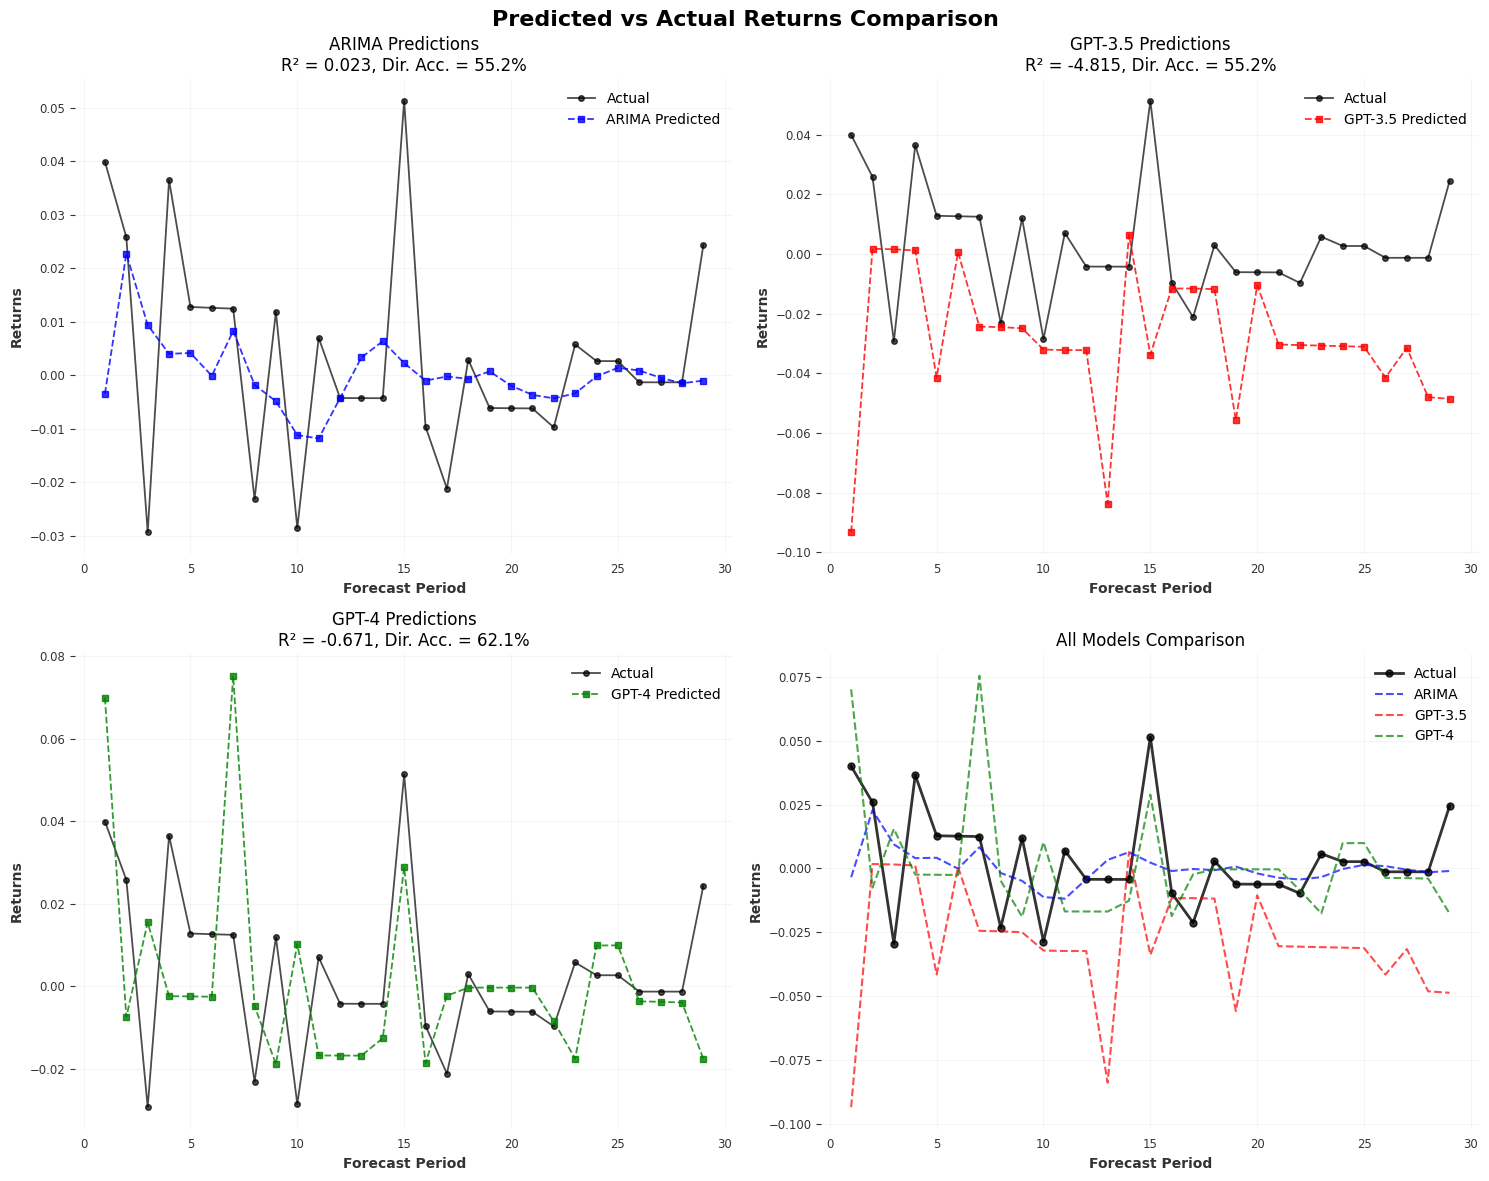

In [28]:
plot_predictions_vs_actual(comparison_results, forecast_horizon=FORECAST_HORIZON)

In this project, it is **expected** that the models will not precisely match the actual return series values. The purpose of this plot is mainly to visualize the predicted versus actual returns and not to assess value accuracy. 

We can observe a **linear and smoothed trend** from the **ARIMA model**, which is consistent with its statistical and stationary assumptions. In contrast, **GPT-3.5** and **GPT-4** display a **more dynamic and nonlinear behavior**, producing sharper fluctuations and less stable trends.

Despite the differences in predicted values, all models show a **similar level of directional understanding**, which is close to random performance. This emphasizes the inherent difficulty of forecasting stock returns providing only the historic time-series data.

#### 💰 Cumulative Trading Performance Comparison

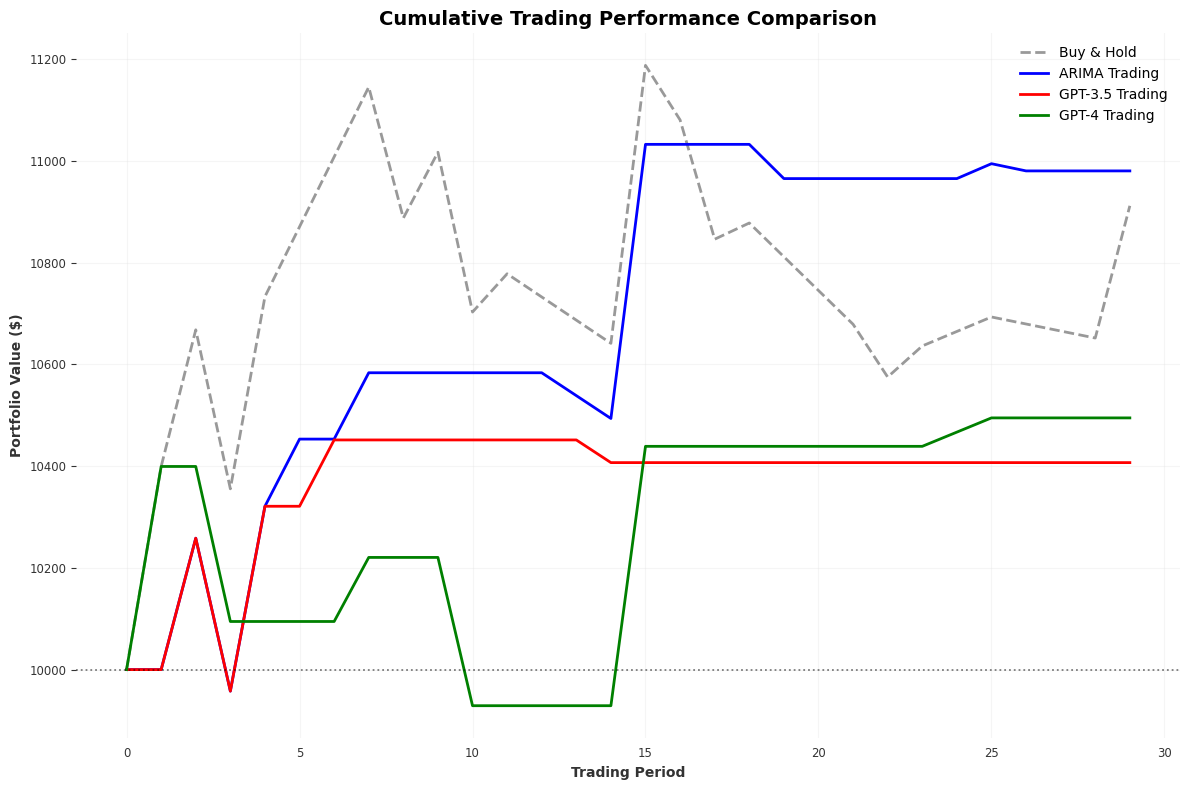

In [29]:
plot_cumulative_returns_simulation(comparison_results, initial_capital=INITIAL_CAPITAL)

This plot shows the **cumulative portfolio value** over the 30-day trading horizon for different trading approaches:  
**Buy & Hold**, **ARIMA-based trading**, **GPT-3.5 trading**, and **GPT-4 trading**.

_Definition_:
The **Buy & Hold** strategy (gray dashed line) represents a **baseline investor** who invests once at the beginning and holds the asset throughout the entire period without making any trades.  


The LLM-based models (GPT-3.5 and GPT-4) show more active trading behavior, but their results are unstable and inconsistent, reflecting the randomness and noise in real market movements. The Buy & Hold strategy still performs better than all model-based approaches, which is common in stock forecasting.

In the end, even with advanced models, predicting market returns doesn’t always lead to better trading results, highlighting just how unpredictable and challenging stock markets really are.

#### Summary Table

In [32]:
display(create_performance_summary_table(comparison_results))


COMPREHENSIVE PERFORMANCE SUMMARY TABLE
  Model     RMSE      MAE      R² Directional Accuracy Total Return Final Capital Profitable Trades Total Trades Best Strategy
  ARIMA 0.018604 0.013061  0.0230               55.17%        9.90%     $10990.20            57.78%         11.4     threshold
GPT-3.5 0.045388 0.035505 -4.8151               55.17%        2.75%     $10275.38            52.98%          4.1     threshold
  GPT-4 0.024334 0.018793 -0.6715               62.07%        5.83%     $10582.92            56.20%         14.0      relative


,Model,RMSE,MAE,R²,Directional Accuracy,Total Return,Final Capital,Profitable Trades,Total Trades,Best Strategy
0,ARIMA,0.018604,0.013061,0.0230,55.17%,9.90%,$10990.20,57.78%,11.4,threshold
1,GPT-3.5,0.045388,0.035505,-4.8151,55.17%,2.75%,$10275.38,52.98%,4.1,threshold
2,GPT-4,0.024334,0.018793,-0.6715,62.07%,5.83%,$10582.92,56.20%,14.0,relative


## Conclusion

This project explored the application of Large Language Models (LLMs) for stock market prediction, specifically focusing on S&P 500 returns forecasting. The research compared traditional statistical methods (ARIMA) with modern LLM-based approaches (GPT-3.5 and GPT-4) using a evaluation framework that included statistical metrics, but focuses more on practical trading performance assessment.

### 🎯 **Key Findings**

1. **Limited Predictive Performance Across All Models**
   - All models demonstrated **directional accuracy close to random** (55-62%), indicating that none consistently outperformed chance in predicting market direction
   - Statistical metrics (RMSE, MAE, R²) showed poor fit across all approaches, confirming the challenging nature of financial time series prediction

2. **Model Behavior Differences**
   - **ARIMA** produced **linear and smoothed predictions**, consistent with its statistical assumptions and stationarity requirements
   - **LLM models** (GPT-3.5 and GPT-4) exhibited **more dynamic and nonlinear behavior** with sharper fluctuations, potentially capturing complex patterns but failing to translate into superior accuracy
   - Despite different prediction patterns, all models converged to similar **overall performance levels**

### 🔍 **Implications for Financial Forecasting**

The results reinforce the **Efficient Market Hypothesis** and highlight several critical insights:

- **Market Complexity**: Even sophisticated models like GPT-4 struggle with the inherent randomness and complexity of financial markets
- **Data Limitations**: Historical return patterns may not contain sufficient predictive signals for future performance
- **Model Limitations**: Both statistical and deep learning approaches face challenges when applied to highly volatile, non-stationary financial data
